
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


In [ ]:
# data processing
import numpy as np
import pandas as pd

# statistical functions
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes.  Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación. 


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

Los supuestos para el análisis entre las distintas medias de las distribuciones de los tiempos cada uno de los métodos de fabricación, si se quieren aplicar métodos paramétricos son:
1. Las muestras deben tener una distribución normal
2. Sus varianzas deben ser equivalentes para poder ser comparables
3. Las muestras deben ser independientes

Dados estos supuestos, se pueden utilizar métodos paramétricos para comprobar si sus distribuciones muestran evidencias estadísticas significativas de ser diferentes.

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?


In [ ]:
# importar datos
linea_montaje = pd.read_csv("datos/linea_montaje.csv")

,minutos,metodo
0,4.166484,A
1,4.887466,A
2,0.727608,A
3,8.280542,A
4,1.413129,A


Comencemos por graficar las distribuciones de cada grupo para tener una intuición sobre las características de las mismas.

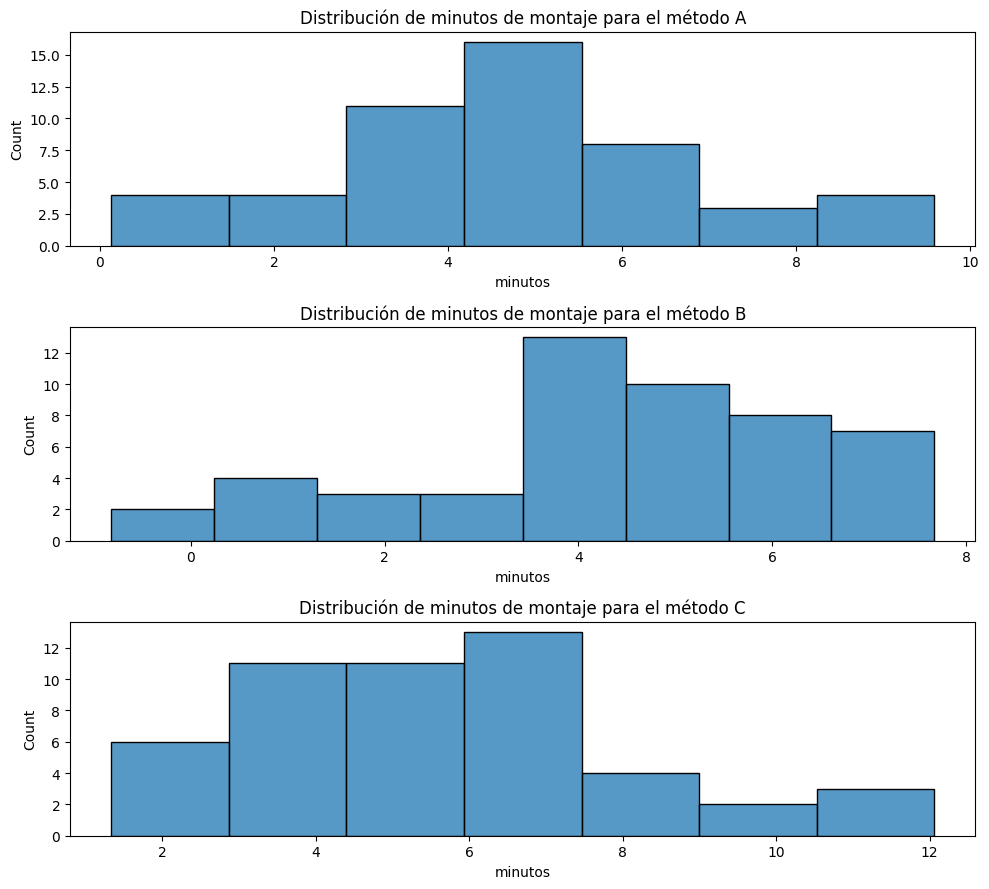

In [49]:
fig, axes = plt.subplots(3,1,figsize=(10,9))
for ax, grupo in zip(axes.flat, linea_montaje.metodo.unique()):
    ax.set_title(f"Distribución de minutos de montaje para el método {grupo}")
    grupo_df = linea_montaje[linea_montaje["metodo"] == grupo]
    sns.histplot(grupo_df["minutos"], ax=ax)

plt.tight_layout()
plt.show()

Se aplican dos tests de contraste de hipótesis, Shapiro-Wilk y Kolmogorov-Smirnoff, a cada una de las distribuciones para comprobar la bondad del ajuste a una normal.

Hipótesis:
- **H₀ (Hipótesis nula)**: La muestra sigue una distribución normal.
- **H₁ (Hipótesis alternativa)**: La muestra no sigue una distribución normal.


In [29]:
print("Resultados del test de bondad de ajuste Shapiro-Wilk:")
for grupo in linea_montaje.metodo.unique():
    grupo_df = linea_montaje[linea_montaje["metodo"] == grupo]
    print(f"El p-valor para el grupo {grupo} es {round(stats.shapiro(grupo_df['minutos'])[1],3)}")

print("\n\nResultados del test de bondad de ajuste Kolmogorov-Smirnoff:")
for grupo in linea_montaje.metodo.unique():
    grupo_df = linea_montaje[linea_montaje["metodo"] == grupo]
    media = np.mean(grupo_df["minutos"])
    desv_tip = np.std(grupo_df["minutos"])
    print(f"El p-valor para el grupo {grupo} es {round(stats.kstest(grupo_df['minutos'],'norm', args=(media, desv_tip))[1],3)}")

Resultados del test de bondad de ajuste Shapiro-Wilk:
El p-valor para el grupo A es 0.672
El p-valor para el grupo B es 0.032
El p-valor para el grupo C es 0.195


Resultados del test de bondad de ajuste Kolmogorov-Smirnoff:
El p-valor para el grupo A es 0.841
El p-valor para el grupo B es 0.53
El p-valor para el grupo C es 0.623


Los tests de normalidad indican con unanimidad, tomando como referencia un 5% de significación, que los grupos A y C presentan una distribución normal. Sin embargo, el grupo B no presenta de forma tan clara dicha distribución, obteniendo de ambos tests una discrepancia en la cual el test de Shapiro apunta a una distribución no normal y el Kolmogorov Smirnoff a una normal. 

En vista de estos resultados, se va a continuar con precaución la evaluación de diferencia de medias, ya que no está clara la evidencia de normalidad de las distribuciones.


A continuación, se van a llevar a cabo tests para comprobar la homocedasticidad entre las distribuciones. Dado que las distribuiciones del grupo B y grupo C parecen ligeramente sesgadas, y más importante, que la distribución del grupo B no es claramente normal, se va a utilizar el test de Levene.

Hipótesis:
- **H₀ (Hipótesis nula)**: Las varianzas de los grupos son iguales (homocedasticidad).
- **H₁ (Hipótesis alternativa)**: Al menos una de las varianzas de los grupos es diferente (heterocedasticidad).

In [50]:
distribuciones_grupos = [linea_montaje.loc[linea_montaje["metodo"]==grupo, "minutos"] for grupo in linea_montaje["metodo"].unique()]

stats.levene(*distribuciones_grupos)

LeveneResult(statistic=np.float64(0.5121686332045056), pvalue=np.float64(0.6002599830733366))

Los resultados del test de Levene, con un valor de significación del 5%, sugieren que no hay evidencia de desigualdad en las varianzas entre los grupos evaluados, ya que el p-valor obtenido (p-valor = 0.6) supera ampliamente el umbral de significación. Esto indica que podemos asumir homocedasticidad en los datos.

Finalmente, se procede a medir si las medias de las distribuciones de los 3 métodos son similares o existen diferencias significativas entre ellas mediante un test ANOVA.

Sus hipótesis son:

- **H₀ (Hipótesis nula)**: Las medias de todos los grupos son iguales.
- **H₁ (Hipótesis alternativa)**: Al menos una de las medias de los grupos es diferente.

In [51]:
stats.f_oneway(*distribuciones_grupos)

F_onewayResult(statistic=np.float64(4.275128289148849), pvalue=np.float64(0.015679251126397998))

Los resultados del análisis ANOVA, considerando un nivel de significación del 5%, muestran evidencia suficiente para rechazar la hipótesis nula de igualdad de medias entre los grupos (p-valor = 0.015). Esto invita a realizar un test de Tukey para encontrar cuales de estas distribuciones son diferentes.

In [58]:
print(pairwise_tukeyhsd(endog=linea_montaje["minutos"],groups=linea_montaje["metodo"],alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B   -0.356 0.6924 -1.3861 0.6741  False
     A      C   0.8798 0.1105 -0.1504 1.9099  False
     B      C   1.2358 0.0142  0.2056 2.2659   True
---------------------------------------------------


Los resultados del test de Tukey indican que no hay diferencias significativas entre los grupos A y B (p = 0.6924) ni entre A y C (p = 0.1105), ya que en ambos casos los p-valores superan el nivel de significación del 5%. Sin embargo, sí se observa una diferencia significativa entre los grupos B y C (p = 0.0142), lo que sugiere que estos dos grupos tienen medias distintas en la variable estudiada. El tamaño de este efecto se puede comprobar visualmente ploteando sus medias:


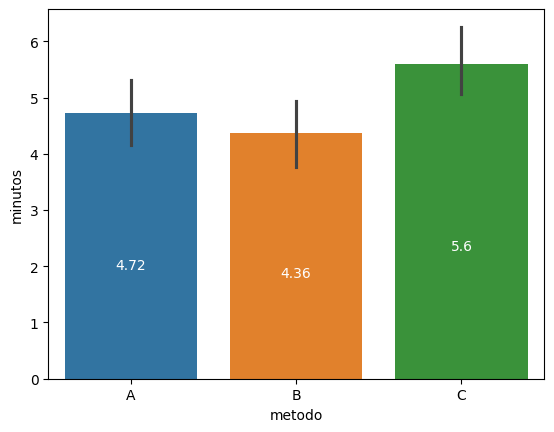

In [ ]:
ax = sns.barplot(data=linea_montaje, y="minutos", x="metodo", hue="metodo")

# añadir data labels
for bar in ax.patches:
    height = bar.get_height()
    x_position = bar.get_x() + bar.get_width() / 2
    ax.text(x_position, height/2 - height/2*0.2, round(height,2), ha='center', va='bottom', color='white')
    
plt.show()

Como se observa, el test de Tukey no ha encontrado que la diferencia de medias de las distribuciones entre los grupos A y C sean significativas, sin embargo la diferencia que se observa entre los grupos B y C sí que se considera un efecto significativo.

#### Ejercicio 2: Densidad de Fluidos 

In [ ]:
# importar datos
densidad_fluidos = pd.read_csv("datos/densidad_fluidos.csv")

densidad                                                        \
               count       mean       std        min        25%        50%   
temperatura                                                                  
100            100.0  21.729410  0.092615  21.472837  21.678719  21.727053   
125            100.0  21.532402  0.102713  21.323342  21.443228  21.539059   
150            100.0  21.766618  0.110576  21.429454  21.693158  21.769963   
175            100.0  21.903682  0.113220  21.618009  21.817386  21.896423   

                                   
                   75%        max  
temperatura                        
100          21.781399  21.928896  
125          21.587963  21.822971  
150          21.831839  22.152903  
175          21.977595  22.170432



La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


In [84]:
densidad_fluidos.groupby("temperatura").describe()

densidad                                                        \
               count       mean       std        min        25%        50%   
temperatura                                                                  
100            100.0  21.729410  0.092615  21.472837  21.678719  21.727053   
125            100.0  21.532402  0.102713  21.323342  21.443228  21.539059   
150            100.0  21.766618  0.110576  21.429454  21.693158  21.769963   
175            100.0  21.903682  0.113220  21.618009  21.817386  21.896423   

                                   
                   75%        max  
temperatura                        
100          21.781399  21.928896  
125          21.587963  21.822971  
150          21.831839  22.152903  
175          21.977595  22.170432



1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?

Como paso previo, es interesante graficar las distribuciones de densidad para las distintas mediciones de temperatura en el sistema.

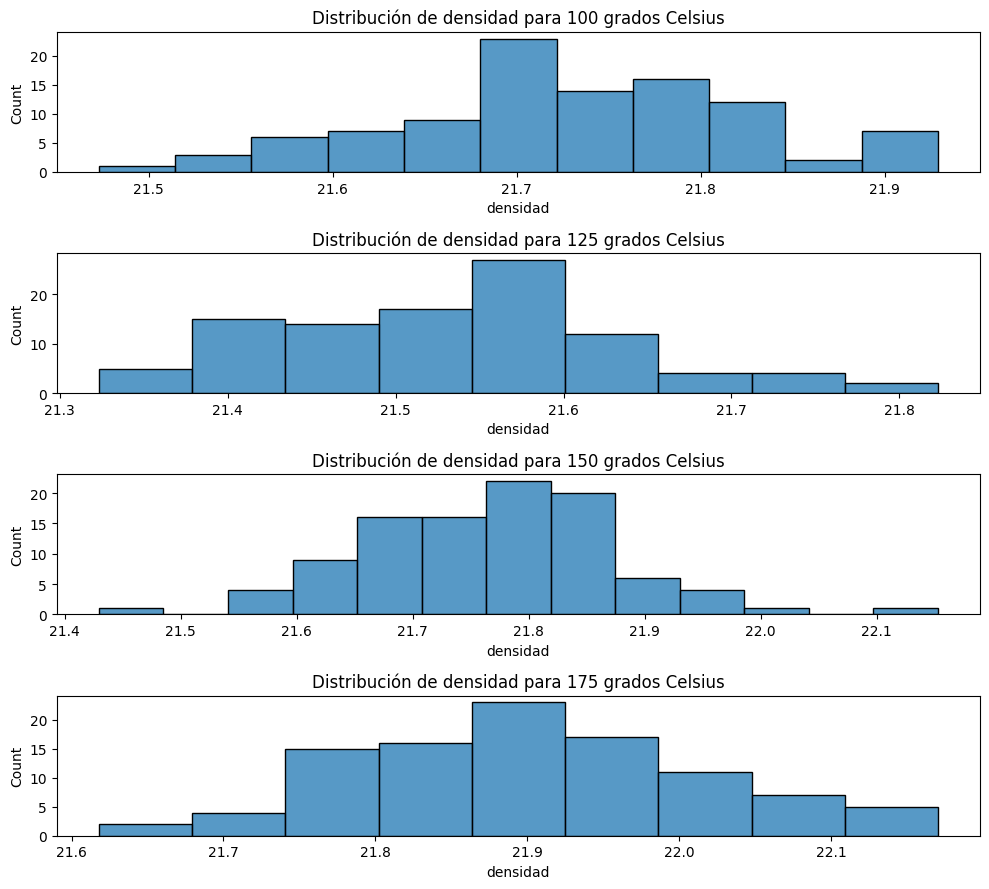

In [79]:
fig, axes = plt.subplots(densidad_fluidos["temperatura"].nunique(),1,figsize=(10,9))
for ax, grupo in zip(axes.flat, densidad_fluidos["temperatura"].unique()):
    ax.set_title(f"Distribución de densidad para {grupo} grados Celsius")
    grupo_df = densidad_fluidos[densidad_fluidos["temperatura"] == grupo]
    sns.histplot(grupo_df["densidad"], ax=ax)

plt.tight_layout()
plt.show()

Se aplican dos tests de contraste de hipótesis, Shapiro-Wilk y Kolmogorov-Smirnoff, a cada una de las distribuciones para comprobar la bondad del ajuste a una normal.

Hipótesis:
- **H₀ (Hipótesis nula)**: La muestra sigue una distribución normal.
- **H₁ (Hipótesis alternativa)**: La muestra no sigue una distribución normal.


In [82]:
print("Resultados del test de bondad de ajuste Shapiro-Wilk:")
for grupo in densidad_fluidos["temperatura"].unique():
    grupo_df = densidad_fluidos[densidad_fluidos["temperatura"] == grupo]
    print(f"El p-valor para el grupo {grupo} es {round(stats.shapiro(grupo_df['densidad'])[1],3)}")

print("\n\nResultados del test de bondad de ajuste Kolmogorov-Smirnoff:")
for grupo in densidad_fluidos["temperatura"].unique():
    grupo_df = densidad_fluidos[densidad_fluidos["temperatura"] == grupo]
    media = np.mean(grupo_df["densidad"])
    desv_tip = np.std(grupo_df["densidad"])
    print(f"El p-valor para el grupo {grupo} es {round(stats.kstest(grupo_df['densidad'],'norm', args=(media, desv_tip))[1],3)}")

Resultados del test de bondad de ajuste Shapiro-Wilk:
El p-valor para el grupo 100 es 0.655
El p-valor para el grupo 125 es 0.085
El p-valor para el grupo 150 es 0.355
El p-valor para el grupo 175 es 0.658


Resultados del test de bondad de ajuste Kolmogorov-Smirnoff:
El p-valor para el grupo 100 es 0.947
El p-valor para el grupo 125 es 0.629
El p-valor para el grupo 150 es 0.914
El p-valor para el grupo 175 es 0.92


Los tests de normalidad afirman con unanimidad, tomando como referencia un 5% de significación, que ninguno de los grupos de temperatura presentan evidencias estadisticas significativas para rechazar la hipótesis nula de ajuste a una distribución normal. 

A continuación, se van a llevar a cabo tests para comprobar la homocedasticidad entre las distribuciones. Se va a utilizar el test de Barlett.

Hipótesis:
- **H₀ (Hipótesis nula)**: Las varianzas de los grupos son iguales (homocedasticidad).
- **H₁ (Hipótesis alternativa)**: Al menos una de las varianzas de los grupos es diferente (heterocedasticidad).

In [87]:
distribuciones_grupos_temperatura = [densidad_fluidos.loc[densidad_fluidos["temperatura"]==grupo, "densidad"] for grupo in densidad_fluidos["temperatura"].unique()]

stats.levene(*distribuciones_grupos_temperatura)

LeveneResult(statistic=np.float64(1.3647908525254946), pvalue=np.float64(0.25311302633232835))

Los resultados del test de Barlett, con un valor de significación del 5%, sugieren que no hay evidencia de desigualdad en las varianzas entre los grupos evaluados, ya que el p-valor obtenido (p-valor = 0.25) supera ampliamente el umbral de significación. Esto indica que podemos asumir homocedasticidad en los datos.

Finalmente, se procede a medir si las medias de las distribuciones de los 4 grupos de temperatura son similares o existen diferencias significativas entre ellas mediante un test ANOVA.

Sus hipótesis son:

- **H₀ (Hipótesis nula)**: Las medias de todos los grupos son iguales.
- **H₁ (Hipótesis alternativa)**: Al menos una de las medias de los grupos es diferente.

In [88]:
stats.f_oneway(*distribuciones_grupos_temperatura)

F_onewayResult(statistic=np.float64(212.84277610615817), pvalue=np.float64(3.327798065119595e-82))

Los resultados del análisis ANOVA, muestran evidencia suficiente para rechazar la hipótesis nula de igualdad de medias entre los grupos a un nivel de significación extremadamente bajo, prácticamente 0. Esto invita a realizar un test de Tukey para encontrar cuales de estas distribuciones son diferentes.

In [89]:
print(pairwise_tukeyhsd(endog=densidad_fluidos["densidad"],groups=densidad_fluidos["temperatura"],alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   100    125   -0.197    0.0 -0.2353 -0.1587   True
   100    150   0.0372 0.0609 -0.0011  0.0756  False
   100    175   0.1743    0.0  0.1359  0.2126   True
   125    150   0.2342    0.0  0.1959  0.2726   True
   125    175   0.3713    0.0  0.3329  0.4096   True
   150    175   0.1371    0.0  0.0987  0.1754   True
----------------------------------------------------


Según el test de ANOVA y los resultados del test de Tukey, existen diferencias significativas entre las medias de las distribuciones de las densidades para los distintos grupos de temperatura. Todas los grupos se consideran significativamente diferentes a nivel estadístico, a excepción de las distribuciones de las temperaturas 100 y 150, que no alcanzan el nivel de significación del 5% marcado para este experimento, por lo que se acepta la hipótesis nula de que sus medias son equivalentes.

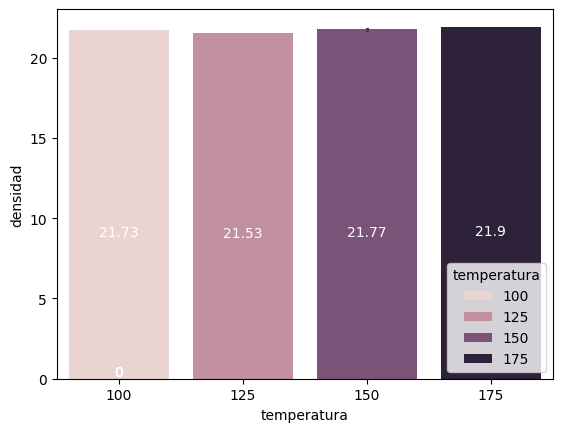

In [90]:
ax = sns.barplot(data=densidad_fluidos, y="densidad", x="temperatura", hue="temperatura")

# añadir data labels
for bar in ax.patches:
    height = bar.get_height()
    x_position = bar.get_x() + bar.get_width() / 2
    ax.text(x_position, height/2 - height/2*0.2, round(height,2), ha='center', va='bottom', color='white')
    
plt.show()

Como se observa, las medias de las densidades para los grupos de temperatura 100 y 150 son las más similares, por lo que no es de extrañar que estas sean consideradas como estadísticamente similares.

3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

Agrupando las distribuciones para las temperaturas de 100 y 125 y las de 150 y 175, que ya se conoce que presentan homocestaticidad y distribución normal, se puede aplicar el test de ANOVA.

In [98]:
densidad_fluidos["temperatura_agrupada"] = np.where(densidad_fluidos["temperatura"] < 150, "100-125", "150-175")

stats.f_oneway(densidad_fluidos.loc[densidad_fluidos["temperatura_agrupada"]=="100-125","densidad"],
               densidad_fluidos.loc[densidad_fluidos["temperatura_agrupada"]=="150-175","densidad"])

F_onewayResult(statistic=np.float64(228.90715320553457), pvalue=np.float64(3.5638496349218163e-41))

Según el ANOVA, dados los datos de la distribución existen muy pocas probabilidades de que la hipótesis nula sea cierta, por lo que es posible afirmar con un alto nivel de significación que existen evidencias estadísticas de que las medias de ambas distribuciones sean diferentes. El gráfico inferior aporta un apoyo visual para comprobar dicho efecto.

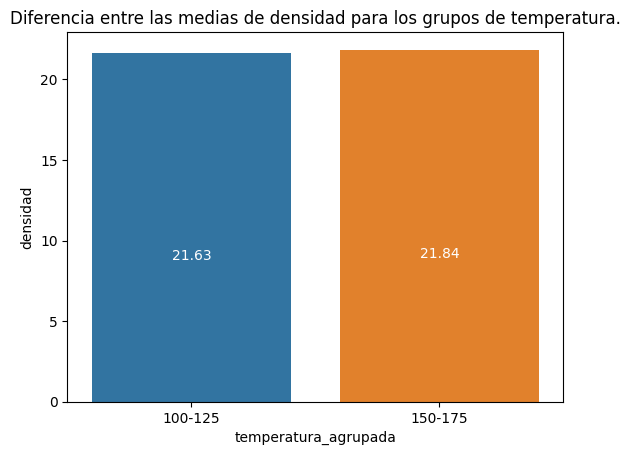

In [99]:
plt.title("Diferencia entre las medias de densidad para los grupos de temperatura.")
ax = sns.barplot(data=densidad_fluidos, y="densidad", x="temperatura_agrupada", hue="temperatura_agrupada")

# añadir data labels
for bar in ax.patches:
    height = bar.get_height()
    x_position = bar.get_x() + bar.get_width() / 2
    ax.text(x_position, height/2 - height/2*0.2, round(height,2), ha='center', va='bottom', color='white')
    
plt.show()

In [2]:
# Tu codigo aqui